# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Checkpoint" data-toc-modified-id="Checkpoint-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Checkpoint</a></div><div class="lev1 toc-item"><a href="#Build-Model" data-toc-modified-id="Build-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build Model</a></div><div class="lev2 toc-item"><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Import Libraries</a></div><div class="lev2 toc-item"><a href="#Set-Hyperparameters" data-toc-modified-id="Set-Hyperparameters-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Set Hyperparameters</a></div><div class="lev2 toc-item"><a href="#Build-Graph" data-toc-modified-id="Build-Graph-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Build Graph</a></div><div class="lev1 toc-item"><a href="#Model-Visualization" data-toc-modified-id="Model-Visualization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model Visualization</a></div><div class="lev1 toc-item"><a href="#Train" data-toc-modified-id="Train-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train</a></div>

# Checkpoint

In [1]:
import h5py

In [2]:
with h5py.File('/Users/lizhn7/Downloads/EXPERIMENT/COPA/RN/data/embedding.h5', 'r') as fh:
    embedding = fh['embedding'][:]
    
with h5py.File('/Users/lizhn7/Downloads/EXPERIMENT/COPA/RN/data/train.h5', 'r') as fh:
    xpTrain = fh['xpTrain'][:]
    xaTrain = fh['xaTrain'][:]
    xqTrain = fh['xqTrain'][:]
    yceTrain = fh['yceTrain'][:]
    yhiTrain = fh['yhiTrain'][:]
    
with h5py.File('/Users/lizhn7/Downloads/EXPERIMENT/COPA/RN/data/test.h5', 'r') as fh:
    xpTest = fh['xpTest'][:]
    xa1Test = fh['xa1Test'][:]
    xa2Test = fh['xa2Test'][:]
    xqTest = fh['xqTest'][:]
    yTest = fh['yTest'][:]

# Build Model

## Import Libraries

In [28]:
from keras.layers import Lambda, Input, Embedding, Dropout, GRU, RepeatVector, Concatenate, concatenate, TimeDistributed, Dense, BatchNormalization, Activation, Flatten
from keras.models import Model
import keras.backend as K
from keras.regularizers import l2
from keras.constraints import maxnorm
from keras.callbacks import*
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Set Hyperparameters

In [19]:
MAX_LEN = 13
MAX_Q_LEN = 6
VOCAB_SIZE = 3371
VOCAB_Q_SIZE = 11
EMBEDDING_SIZE = 300
EMBEDDING_Q_SIZE = 4
GRU_SIZE = 296
GRU_Q_SIZE = 8
DROPOUT_RATE = 0.2
L2_NORM = 1e-4
HIDDEN_SIZE = 100
WEIGHT_CONSTRAINT = 2.
DELTA = 0.009
BATCH_SIZE = 200
NUM_EPOCHS = 1024

## Build Graph

In [5]:
def hinge(y_true, y_pred):
    """
    Define hinge loss function
    """
    return K.mean(K.maximum(DELTA - y_true * y_pred, 0.), axis=-1)

```pyhton
def attention_context(x):
    """
    Compute context with attention weight
    """
    pre, alt = x[:, :MAX_LEN, :], x[:, :MAX_LEN, :]
    attention_energies = K.batch_dot(pre, alt, axes=(2, 2))
    attention_energies = K.reshape(attention_energies, (-1, MAX_LEN))
    attention_weights = K.softmax(attention_energies)
    attention_weights = K.reshape(attention_weights, (-1, MAX_LEN, MAX_LEN))
    attention_context = K.batch_dot(attention_weights, pre, axes=(2, 1))
    return K.concatenate((attention_context, alt))
```

In [21]:
def attention_context(x):
    """
    Compute context with attention weight
    """
    pre, alt = x[:, :MAX_LEN, :], x[:, :MAX_LEN, :]
    attention_energies = K.batch_dot(pre, alt, axes=(2, 2))
    attention_energies = K.reshape(attention_energies, (-1, MAX_LEN))
    attention_weights = K.softmax(attention_energies)
    attention_weights = K.reshape(attention_weights, (-1, MAX_LEN, MAX_LEN))
    attention_maps1 = K.batch_dot(attention_weights, pre, axes=(2, 1))
    attention_maps2 = K.batch_dot(attention_weights, alt, axes=(2, 1))
    return K.concatenate((attention_maps1, attention_maps2))

In [25]:
def feature_map():
    """
    Build Attention GRU feature maps
    """
    inputs = Input(shape=(MAX_LEN*2,), name='INPUT')
    emb_seq = Embedding(VOCAB_SIZE, 
                        EMBEDDING_SIZE, 
                        weights=[embedding], 
                        mask_zero=True, 
                        trainable=False, 
                        name='EMBEDDING')(inputs)
    gru = GRU(GRU_SIZE, 
              return_sequences=True, 
              implementation=0, 
              dropout=DROPOUT_RATE, 
              recurrent_dropout=DROPOUT_RATE,
              kernel_regularizer=l2(L2_NORM),
              recurrent_regularizer=l2(L2_NORM),
              name='GRU')(emb_seq)
    gru = Dropout(DROPOUT_RATE, name='DROPOUT_FM')(gru)
    att_maps = Lambda(attention_context, name='ATTENTION_MAPS')(gru)
    model = Model(inputs=[inputs], outputs=[att_maps])
    return model

In [26]:
model = feature_map()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           (None, 26)                0         
_________________________________________________________________
EMBEDDING (Embedding)        (None, 26, 300)           1011300   
_________________________________________________________________
GRU (GRU)                    (None, 26, 296)           530136    
_________________________________________________________________
DROPOUT_FM (Dropout)         (None, 26, 296)           0         
_________________________________________________________________
ATTENTION_MAPS (Lambda)      (None, 13, 592)           0         
Total params: 1,541,436
Trainable params: 530,136
Non-trainable params: 1,011,300
_________________________________________________________________


In [27]:
def question_encoder():
    """
    Build question encoder
    """
    inputs = Input(shape=(MAX_Q_LEN,), name='INPUT')
    emb_seq = Embedding(VOCAB_Q_SIZE, 
                        EMBEDDING_Q_SIZE, 
                        mask_zero=True, 
                        input_length=MAX_Q_LEN, 
                        trainable=True, 
                        name='EMBEDDING_Q')(inputs)
    gru = GRU(GRU_Q_SIZE, 
              return_sequences=False, 
              implementation=0, 
              dropout=DROPOUT_RATE, 
              recurrent_dropout=DROPOUT_RATE,
              kernel_regularizer=l2(L2_NORM),
              recurrent_regularizer=l2(L2_NORM),
              name='GRU_Q')(emb_seq)
    model = Model(inputs=[inputs], outputs=[gru])
    return model

In [31]:
def relation_networks():
    """
    Build relation networks
    """
    AttGRU = feature_map()
    QueENC = question_encoder()
    joint = []
    inputs_p = Input(shape=(MAX_LEN,), name='INPUT_P')
    joint.append(inputs_p)
    inputs_a = Input(shape=(MAX_LEN,), name='INPUT_A')
    joint.append(inputs_a)
    inputs = Concatenate(axis=1, name='INPUT')(joint)
    inputs_q = Input(shape=(MAX_Q_LEN,), name='INPUT_Q')
    feaMap = AttGRU(inputs)
    queSeq = QueENC(inputs_q)
    queSeq = RepeatVector(MAX_LEN, name='Q_ENC')(queSeq)
    feaComb = concatenate([feaMap, queSeq], axis=-1, name='FEA_COMB')
    mlp = TimeDistributed(Dense(HIDDEN_SIZE,
                                activation=None,
                                kernel_regularizer=l2(L2_NORM),
                                kernel_constraint=maxnorm(WEIGHT_CONSTRAINT)),
                          name='MLP')(feaComb)
    mlp = BatchNormalization(name='BN')(mlp)
    mlp = Activation('relu', name='RELU')(mlp)
    mlp = Dropout(DROPOUT_RATE, name='DROPOUT_1')(mlp)
    #ewSum = Lambda(lambda x: K.sum(x, axis=1), name='ELEMENT-WISE_SUM')(mlp)
    #ewSum = Dropout(DROPOUT_RATE, name='DROPOUT_2')(ewSum)
    ewSum = Flatten()(mlp)
    outputs = Dense(1, 
                    activation='tanh', 
                    kernel_regularizer=l2(L2_NORM),
                    kernel_constraint=maxnorm(WEIGHT_CONSTRAINT),
                    name='OUTPUT')(ewSum)
    model = Model(inputs=[inputs_p, inputs_a, inputs_q], outputs=[outputs])
    model.compile(loss=hinge, optimizer='rmsprop')
    return model

# Model Visualization

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
INPUT_P (InputLayer)             (None, 13)            0                                            
____________________________________________________________________________________________________
INPUT_A (InputLayer)             (None, 13)            0                                            
____________________________________________________________________________________________________
INPUT_Q (InputLayer)             (None, 6)             0                                            
____________________________________________________________________________________________________
INPUT (Concatenate)              (None, 26)            0           INPUT_P[0][0]                    
                                                                   INPUT_A[0][0]           

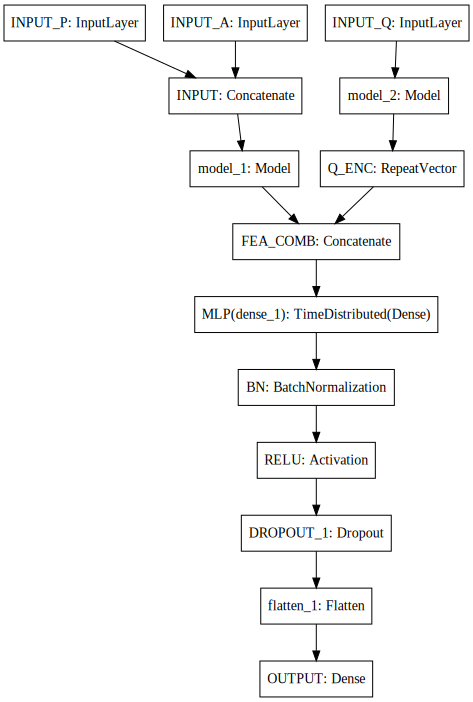

In [32]:
K.clear_session()
model = relation_networks()
model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Train

In [33]:
from tqdm import tqdm
import numpy as np

In [34]:
def accuracy(p, a1, a2, q, actu, show=True):
    """
    Calculate Accuracy
    """
    A1 = model.predict([p, a1, q])
    A2 = model.predict([p, a2, q])
    pred = []
    for i in range(len(A1)):
        if A1[i] > A2[i]:
            pred.append(1)
        else:
            pred.append(2)
    S = sum([1 for i in range(len(pred)) if pred[i] == actu[i]])
    ACC = S / len(actu)
    if show:
        print('Accuracy: \t%.9f' % (ACC))
    return np.array([ACC])

def plot_acc(acc, num_epochs):
    """
    Plot Accuracy
    """
    print('MAX Accuracy: \t%.3f' % (max(acc)))
    epochs = list(range(1, num_epochs+1))
    plt.figure(figsize=(10, 8))
    plt.plot(epochs, acc, label="Accuracy", color="red", linewidth=1)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.xticks([i for i in range(1, len(acc), len(acc)//10)])
    plt.grid(True)  
    plt.legend()
    plt.show()
    
def plot_loss(log):
    """
    Plot Loss
    """
    plt.figure(figsize=(10, 8))
    loss = log['loss']
    if 'val_loss' in log:
        val_loss = log['val_loss']
        plt.plot(val_loss, color="r", label="Val Loss")
    plt.plot(loss, color="g", label="Train Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend(loc="best")
    plt.show()

In [35]:
def train(model, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=1, show=True, plot=True):
    """
    Parameters
    ----------
    model :                  training model          
    num_epochs 128:          training epochs   
    batch_size 200:          size of batch 
    verbose :                1
    show True:               show accuracy every epoch
    plot True:               plot accuracy and loss or not
    Returns
    ----------
    The training results
    """
    ACC = []
    history = {}
    for e in range(num_epochs):
        print('EPOCHS', e+1)
        t = model.fit([xpTrain, xaTrain, xqTrain], 
                      yhiTrain,
                      batch_size=batch_size,
                      epochs=1,
                      shuffle=True,
                      verbose=verbose)
        for i, j in t.history.items():
            history[i] = history.get(i, []) + j
        ACC.append(accuracy(xpTest, xa1Test, xa2Test, xqTest, yTest, show=show))
    if plot:
        plot_acc(ACC, num_epochs)
        plot_loss(history)
    ACC = sum([list(i) for i in ACC], [])
    return max(ACC)

In [18]:
train(relation_networks())

EPOCHS 1
Epoch 1/1
2000/2000 [==============================] - 17s - loss: 0.6038    
Accuracy: 	0.496000000
EPOCHS 2
Epoch 1/1
2000/2000 [==============================] - 15s - loss: 0.6057    
Accuracy: 	0.496000000
EPOCHS 3
Epoch 1/1
2000/2000 [==============================] - 14s - loss: 0.5796    
Accuracy: 	0.496000000
EPOCHS 4
Epoch 1/1
2000/2000 [==============================] - 14s - loss: 0.5812    
Accuracy: 	0.496000000
EPOCHS 5
Epoch 1/1
2000/2000 [==============================] - 14s - loss: 0.5833    
Accuracy: 	0.496000000
EPOCHS 6
Epoch 1/1
2000/2000 [==============================] - 15s - loss: 0.5778    
Accuracy: 	0.496000000
EPOCHS 7
Epoch 1/1
2000/2000 [==============================] - 15s - loss: 0.5823    
Accuracy: 	0.496000000
EPOCHS 8
Epoch 1/1
2000/2000 [==============================] - 15s - loss: 0.5755    
Accuracy: 	0.496000000
EPOCHS 9
Epoch 1/1
2000/2000 [==============================] - 14s - loss: 0.5665    
Accuracy: 	0.496000000
EPOCHS 10


KeyboardInterrupt: 

In [37]:
history = model.fit([xpTrain, xaTrain, xqTrain], 
                    yceTrain,
                    batch_size=BATCH_SIZE,
                    epochs=3,
                    shuffle=True,
                    verbose=1)

Epoch 1/3
2000/2000 [==============================] - 8s - loss: 0.0935     
Epoch 2/3
2000/2000 [==============================] - 6s - loss: 0.0638     
Epoch 3/3
2000/2000 [==============================] - 6s - loss: 0.0529     


In [39]:
model.predict([xpTest, xa1Test, xqTest]) == model.predict([xpTest, xa2Test, xqTest])

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [

In [106]:
model.predict([xpTest, xa1Test, xqTest])

array([[ 0.04006713],
       [ 0.04317438],
       [ 0.05277794],
       [ 0.0330967 ],
       [ 0.04245253],
       [ 0.04038421],
       [ 0.05393065],
       [ 0.04121786],
       [ 0.03302476],
       [ 0.05620285],
       [ 0.03949131],
       [ 0.03207621],
       [ 0.0378809 ],
       [ 0.05519846],
       [ 0.04921759],
       [ 0.037997  ],
       [ 0.04572457],
       [ 0.06853228],
       [ 0.03380357],
       [ 0.04441269],
       [ 0.03775113],
       [ 0.06172223],
       [ 0.05329597],
       [ 0.06474978],
       [ 0.04547671],
       [ 0.05316555],
       [ 0.04448027],
       [ 0.03722025],
       [ 0.04629617],
       [ 0.05081072],
       [ 0.04030119],
       [ 0.0381727 ],
       [ 0.0391874 ],
       [ 0.04003835],
       [ 0.04010185],
       [ 0.04204791],
       [ 0.03639166],
       [ 0.03304909],
       [ 0.03497537],
       [ 0.03433217],
       [ 0.03903621],
       [ 0.03275463],
       [ 0.04556612],
       [ 0.03986829],
       [ 0.05578475],
       [ 0

In [86]:
model.predict([xpTest, xa2Test, xqTest])

array([[ 0.01095546],
       [ 0.01095458],
       [ 0.01095464],
       [ 0.01095479],
       [ 0.01095467],
       [ 0.0109553 ],
       [ 0.01095562],
       [ 0.01095474],
       [ 0.01095529],
       [ 0.01095544],
       [ 0.01095471],
       [ 0.01095476],
       [ 0.01095471],
       [ 0.01095537],
       [ 0.01095461],
       [ 0.0109547 ],
       [ 0.01095566],
       [ 0.0109555 ],
       [ 0.01095474],
       [ 0.0109546 ],
       [ 0.01095472],
       [ 0.01095541],
       [ 0.01095547],
       [ 0.01095559],
       [ 0.01095464],
       [ 0.01095538],
       [ 0.01095566],
       [ 0.01095472],
       [ 0.01095456],
       [ 0.01095463],
       [ 0.01095532],
       [ 0.01095463],
       [ 0.0109546 ],
       [ 0.01095471],
       [ 0.01095542],
       [ 0.01095461],
       [ 0.01095473],
       [ 0.01095469],
       [ 0.01095531],
       [ 0.01095477],
       [ 0.01095556],
       [ 0.01095472],
       [ 0.01095459],
       [ 0.01095467],
       [ 0.01095473],
       [ 0